<a href="https://colab.research.google.com/github/rineuman/GB2020/blob/master/Gro%C3%9FerBeleg2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL LIBRARIES

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install q keras==2.1

In [ ]:
!pip install imgaug
!pip install Cython
!pip install pycocotools
!pip install kaggle
!pip3 install imgaug

CLONE MATTERPORT REPOSITORY

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [ ]:
! pwd

/content


In [ ]:
import os 
os.chdir('Mask_RCNN')

In [ ]:
#!git clone https://github.com/rineuman/barrierDataset.git
!git clone https://github.com/rineuman/newDataSet.git

fatal: destination path 'newDataSet' already exists and is not an empty directory.


In [ ]:
os.chdir('samples')

In [ ]:
import sys
import random
import math
import re
import time
import json
import skimage.draw
import numpy as np
import cv2
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "barrierDataset/val")

Using TensorFlow backend.


CONFIGURATION

In [ ]:
class BarrierConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "barrier"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"


    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 barriers

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    # RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 108

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS = 5
    
config = BarrierConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

DATASET

In [ ]:
class BarrierDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_barrier(self, dataset_dir, subset):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("barrier", 1, "door")
        self.add_class("barrier", 2, "stair")
        self.add_class("barrier", 3, "lift")

         # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_export_json.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            barriers = [r['region_attributes']for r in a['regions']]

            doorPolygons = []
            stairPolygons = []
            liftPolygons = []
            classIds = []

            for i in range(len(barriers)):
              currentBarrier = barriers[i].get("barrier")
              currentPolygon = polygons[i]
              print(currentBarrier)
              if currentBarrier == "door":
                doorPolygons.append(currentPolygon)
                classIds.append(1)
              elif currentBarrier == "stair":
                stairPolygons.append(currentPolygon)
                classIds.append(2)
              elif currentBarrier == "lift":
                liftPolygons.append(currentPolygon)
                classIds.append(3)
              else:
                print("ERROR NOT door, stair or lift")
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "barrier",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=np.asarray(classIds))
            

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        print("Image Reference ")
        print(self.image_info)
        info = self.image_info[image_id]
        if info["source"] == "barrier":
            return info["path"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bottle dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        #if image_info["source"] != "barrier":
        #    return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]

        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.int32)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            if p['name'] == 'polygon':
              rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            elif p['name'] == 'rect':
              rr, cc = skimage.draw.rectangle((p['y'], p['x']), (p['y'] + p['height'], p['x'] + p['width']))
            elif p['name'] == 'circle':
              rr, cc = skimage.draw.circle(p['cy'], p['cx'], p['r'])

            mask[rr, cc, i] = i

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        return mask.astype(np.bool), info['class_ids'].astype(np.int32)

Extra functions


Train


In [ ]:
# Training dataset
dataset_train = BarrierDataset()
dataset_train.load_barrier("/content/Mask_RCNN/newDataSet", "train")
dataset_train.prepare()

# Validation dataset
dataset_val = BarrierDataset()
dataset_val.load_barrier("/content/Mask_RCNN/newDataSet", "val")
dataset_val.prepare()

{'filename': '6.jpg', 'size': 176984, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 464, 'y': 354, 'width': 111, 'height': 59}, 'region_attributes': {'barrier': 'door'}}, {'shape_attributes': {'name': 'rect', 'x': 12, 'y': 153, 'width': 76, 'height': 47}, 'region_attributes': {'barrier': 'stair'}}, {'shape_attributes': {'name': 'rect', 'x': 223, 'y': 354, 'width': 109, 'height': 58}, 'region_attributes': {'barrier': 'door'}}, {'shape_attributes': {'name': 'rect', 'x': 1793, 'y': 1125, 'width': 55, 'height': 40}, 'region_attributes': {'barrier': 'stair'}}, {'shape_attributes': {'name': 'rect', 'x': 1793, 'y': 1088, 'width': 30, 'height': 24}, 'region_attributes': {'barrier': 'stair'}}], 'file_attributes': {}}
door
stair
door
stair
stair
{'filename': '7.jpg', 'size': 254811, 'regions': [{'shape_attributes': {'name': 'rect', 'x': 1043, 'y': 459, 'width': 65, 'height': 77}, 'region_attributes': {'barrier': 'lift'}}, {'shape_attributes': {'name': 'rect', 'x': 1558, 'y': 599, 'width

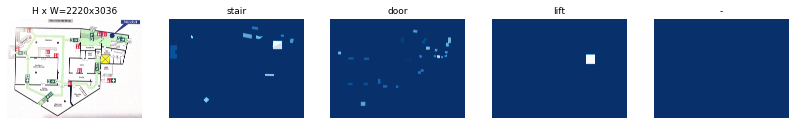

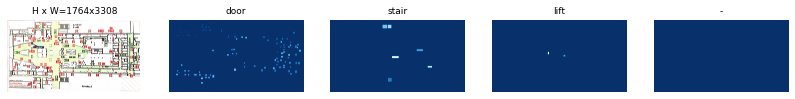

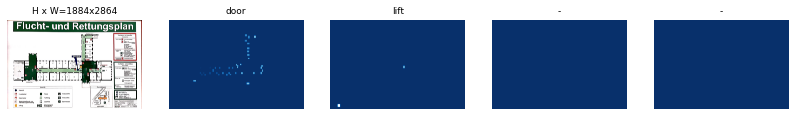

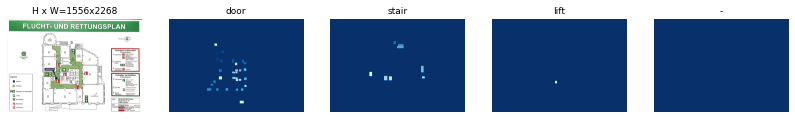

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


CREATE MODEL

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

TRAINING

In [ ]:
#import tensorflow as tf
#import datetime
#%load_ext tensorboard

#sess = tf.Session()

#file_writer = tf.summary.FileWriter('/path/to/logs', sess.graph)

# Tensorflow board
#logdir = os.path.join(
#    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#%tensorboard --logdir logs


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
import imgaug



model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=100, 
            layers='heads',
            augmentation = imgaug.augmenters.OneOf([
                    imgaug.augmenters.Fliplr(1),
                    imgaug.augmenters.Flipud(1),
                    imgaug.augmenters.Affine(rotate=(-90, 90)),
                    imgaug.augmenters.Noop(),
                    imgaug.augmenters.Add(value=25),
                    imgaug.augmenters.Add(value=-25)
                ]))

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE / 10,
#            epochs=2, 
#            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_barrier.h5")
#model.keras_model.save(model_path)
model.keras_model.save_weights(model_path)

print(model_path)


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

import os
import sys
import warnings

import keras.backend as K
import tensorflow as tf

warnings.filterwarnings('ignore', category=FutureWarning)
# suppress warning and error message tf
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Root directory of the project
ROOT_DIR = os.getcwd()
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import model as modellib
from mrcnn import utils
#import landingzone

K.clear_session()
K.set_learning_phase(0)


def h5_to_pb(h5_model, output_dir, model_name, out_prefix="output_"):
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i], out_prefix + str(i + 1))
    sess = K.get_session()
    init_graph = sess.graph.as_graph_def()
    main_graph = tf.compat.v1.graph_util.convert_variables_to_constants(sess, init_graph, out_nodes)
    with tf.gfile.GFile(os.path.join(output_dir, model_name), "wb") as filemodel:
        filemodel.write(main_graph.SerializeToString())
    print(f"pb model: {os.path.join(output_dir, model_name)}")


pb_name_model = "mask_rcnn_landing.pb"
h5_to_pb(model.keras_model, output_dir=MODEL_DIR, model_name=pb_name_model)
"""


DETECTION

In [ ]:
class InferenceConfig(BarrierConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on random image from training set
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, 
                           image_id, use_mini_mask=False)


# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
#original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#    modellib.load_image_gt(dataset_val, inference_config, 
#                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
def get_ax(rows=1, cols=1, size=32):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
print(r['rois'])
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

EVALUATION

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 9)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=1)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    print(AP)
    print(image_id)
    
print("mAP: ", np.mean(APs))